In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable  # CHECK: do I need this?

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# from plots at the end -- TODO: try doing this only with PyTorch.
from scipy.stats import norm

import time


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Simulate data

In [7]:
input_size = 2   # input is theta and z_i
output_size = 2  # output is mu_i and log(sigma_i) 
nn_width = 15

class likelihood_NN(nn.Module):
    
    def __init__(self):
        super(likelihood_NN, self).__init__()
        
    def forward_mean(self, theta, z):
        m = theta[:, None] + torch.sin(z) * z + z
        return m
    
    def forward_sd(self, theta, z):
        s = torch.cos(z)
        return s
    

In [8]:
torch.manual_seed(1789)  # use a fixed seed for simulation data
likelihood_nn = likelihood_NN().to(device)

theta = torch.randn(1)

n = 10000
theta_rep = theta.repeat(n)
z = 5 * torch.randn(n)
# x = torch.randn(n)
x = torch.randn(n, 1)

f_mean = likelihood_nn.forward_mean(theta, z)
f_sd = likelihood_nn.forward_sd(theta, z)

# x = f_mean + x * torch.exp(f_sd)
x = f_mean.reshape(n, 1) + x * torch.exp(f_sd).reshape(n, 1)


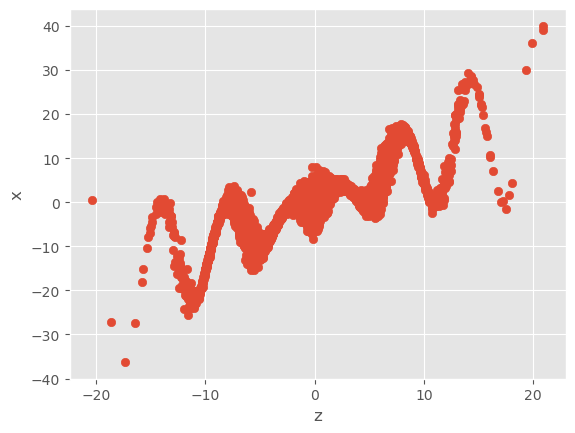

In [9]:
# Let's examine the data, in particular, plot x as a function of z.
# plt.scatter(z.detach.numpy(), x.detach.numpy())
plt.scatter(z.detach().numpy(), x.detach().numpy())
# plt.scatter(z.detach().numpy(), f_mean.detach().numpy(), marker = '^')
plt.xlabel("z")
plt.ylabel("x")
plt.savefig("to_discuss/z_deep.pdf")
plt.show()


/tmp/ipykernel_1684047/3367864121.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


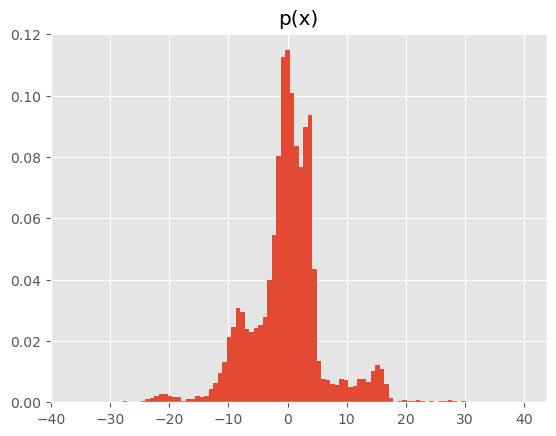

In [10]:
# plot x
nbins = 100
fig, axs = plt.subplots(1, 1)
axs.hist(x.numpy(), bins = nbins, density = True)
axs.set_title("p(x)")
fig.savefig("to_discuss/p_deep.pdf")
fig.show()

### Distributions for ELBO
Can use the same distributions for factorized and amortized VI. For amorizted VI, the arguments `nu_mean_z` and `nu_sd_z` will be the output of the inference network. Note that the joint $p(x, \theta, z)$ uses the known likelihood network.

In [11]:
def log_joint(x, theta, z):
    f_mean = likelihood_nn.forward_mean(theta, z).reshape(n, 1)
    f_sd = likelihood_nn.forward_sd(theta, z).reshape(n, 1)
        
    return -0.5 * torch.sum(z**2) - torch.sum(torch.div((x - f_mean)**2,
                                              2 * torch.exp(f_sd)**2))

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2)\
                          * (z - nu_mean_z)**2)
    print(log_q_theta)
    print(log_q_z)
    return log_q_theta + log_q_z
    

In [12]:
# vectorized version for GPU
def log_joint_v(x, theta, z):
    f_mean = likelihood_nn.forward_mean(theta, z)
    f_sd = likelihood_nn.forward_sd(theta, z)

    return -0.5 * torch.sum(z**2, dim = 1)\
        - torch.sum(torch.div((x - f_mean)**2, 2 * torch.exp(f_sd)**2), dim = 1)


def log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2)\
                          * (z - nu_mean_z)**2, dim = 1)
    return log_q_theta + log_q_z


In [13]:
# TEST: check that the vectorized and non-vectorized log densities return the same output.
if(False):
    theta = theta.to(device)
    z = z.to(device)
    nu_mean_theta = torch.randn(1).to(device)
    nu_sd_theta = torch.exp(torch.randn(1, 1)).to(device)
    nu_mean_z = torch.randn((n, 1)).to(device)
    nu_sd_z = torch.exp(torch.randn((n, 1))).to(device)

    print(log_joint(x, theta, z))
    print(log_joint_v(x.reshape(n, 1), theta.reshape((1, 1)), z.reshape(1, n, 1)))


    log_q_evaluated = log_q(theta, z.reshape(n, 1), nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)

    log_q_v_evaluated = log_q_v(theta, z.reshape(1, n, 1), nu_mean_theta,
                                nu_sd_theta, nu_mean_z, nu_sd_z)

    print(log_q_evaluated)
    print(log_q_v_evaluated)

    print(log_q_evaluated.shape)
    print(log_q_v_evaluated.shape)


### Model class for amortized VI

In [14]:
# Architecture for the inference network (for now stick to three layers.)
inf_input_size = 1  # inference network only takes in x_i

class MCElbo_AVI(torch.nn.Module):
    def __init__(self, inf_nn_width):
        super(MCElbo_AVI, self).__init__()

        # variational parameters for q(theta) # ToDO: set initial value
        self.nu_mean_theta = torch.nn.Parameter(torch.randn(1, 1), requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(torch.randn(1, 1), requires_grad = True)
        
        # define inference neural network for the mean
        self.m1 = nn.Linear(inf_input_size, inf_nn_width)
        self.m2 = nn.Linear(inf_nn_width, inf_nn_width)
        self.m3 = nn.Linear(inf_nn_width, 1)
        
        # define inference neural network for the log sd
        self.s1 = nn.Linear(inf_input_size, inf_nn_width)
        self.s2 = nn.Linear(inf_nn_width, inf_nn_width)
        self.s3 = nn.Linear(inf_nn_width, 1)

        self.mc_samples = 100
        
    def forward_mean(self, x):
        y = F.relu(self.m1(x))
        y = F.relu(self.m2(y))
        y = self.m3(y)
        return y
    
    def forward_log_sd(self, x):
        y = F.relu(self.s1(x))
        y = F.relu(self.s2(y))
        y = self.s3(y)
        return y
    
    def generate_rand(self, m):
        eps_theta = torch.randn((m, 1)).to(device)
        eps_z = torch.randn(m, n, 1).to(device)
        return eps_theta, eps_z
    
    def reparam(self, eps_theta, eps_z, nu_mean_z, nu_sd_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(nu_sd_z).add(nu_mean_z)
    
    def compute_elbo(self, x):
        nu_mean_z = self.forward_mean(x)
        nu_sd_z = torch.exp(self.forward_log_sd(x))
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z, nu_mean_z, nu_sd_z)

        Elbo = log_joint_v(x, theta, z)\
            - log_q_v(theta, z, self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                      nu_mean_z, nu_sd_z)
        return torch.mean(Elbo)
    
    # Additional function to create a common initialization with FVI
    def FVI_param(self, x):
        nu_mean_z = self.forward_mean(x)
        nu_sd_z = self.forward_log_sd(x)
        
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z


### Factorized VI

In [15]:
# Initialize the weights and biases to 0.
# This amounts to starting with all q(z_i)'s a standard Gaussian.
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.01)
        m.bias.data.fill_(0.01)


In [16]:
# Initialisation for FVI
# Generate initial values for variational parameters and use them to initialize FVI.
torch.manual_seed(1954)
init_nn_width = 2
model_av = MCElbo_AVI(init_nn_width).to(device)
x = x.to(device)

# NOTE: by default, parameters of the inference NN are initialized at the same value,
# which means the elements of nu_mean_z and nu_sd_z_log have the same starting value.
nu_mean_theta_init, nu_sd_theta_log_init,\
    nu_mean_z_init, nu_sd_z_log_init = model_av.FVI_param(x)


In [17]:
class MCElbo_FVI(nn.Module):
    def __init__(self, nu_mean_theta_init, nu_sd_theta_log_init,
                 nu_mean_z_init, nu_sd_z_log_init):
        super(MCElbo_FVI, self).__init__()

        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = 100
    
    def generate_rand(self, m):
        eps_theta = torch.randn((m, 1)).to(device)
        eps_z = torch.randn((m, n, 1)).to(device)
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)

    def compute_elbo(self, x):
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z)

        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    self.nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)       


In [18]:
# Sanity check: make sure both models return the same ELBO (within Monte Carlo error)
x = x.to(device)
model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init,
                   nu_mean_z_init, nu_sd_z_log_init).to(device)
print("loss (FVI): ", model.compute_elbo(x))
print("-----")
print("loss (AVI): ", model_av.compute_elbo(x))

loss (FVI):  tensor(-605395., device='cuda:0', grad_fn=<MeanBackward0>)
-----
loss (AVI):  tensor(-605930.4375, device='cuda:0', grad_fn=<MeanBackward0>)


In [19]:
def vi_init(seed, init_manifold = True, init_nn_width = 2):
    torch.manual_seed(seed)
    if (init_manifold):
        model_av = MCElbo_AVI(init_nn_width).to(device)
        nu_mean_theta, nu_sd_theta_log,\
            nu_mean_z, nu_sd_z_log = model_av.FVI_param(x)
    else:
        nu_mean_theta = torch.randn((1, 1))
        nu_sd_theta_log = torch.randn((1, 1))
        nu_mean_z = torch.rand((n, 1))
        nu_sd_z_log = torch.rand((n, 1))
    
    return nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log


In [ ]:
seed = 1954
torch.manual_seed(seed)
init_manifold = False
nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z_init, nu_sd_z_log_init\
        = vi_init(seed, init_manifold)

model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init,
                   nu_mean_z_init, nu_sd_z_log_init).to(device)

n_iter_optimizer = 10
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
loss_saved = torch.empty(n_iter_optimizer)

print_output = True

start_time = time.time()
for i in range(n_iter_optimizer):
        loss = - model.compute_elbo(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data
        if (i % 5000 == 0 and print_output):
            print("loss", loss_saved[i])
end_time = time.time()
run_time = end_time - start_time


In [39]:
def run_fvi(seed, n_iter_optimizer, init_manifold = False, print_output = False):
    torch.manual_seed(seed)
    nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z_init, nu_sd_z_log_init\
        = vi_init(seed, init_manifold)

    model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init,
                       nu_mean_z_init, nu_sd_z_log_init).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    loss_saved = torch.empty(n_iter_optimizer)

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss = - model.compute_elbo(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data
        if (i % 5000 == 0 and print_output):
            print("loss", loss_saved[i])
    end_time = time.time()
    run_time = end_time - start_time
    return loss_saved, run_time

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)  # 1e-2
# # x_torch = Variable(torch.tensor(x), requires_grad = False)

# n_iter_optimizer = int(20e3)
# loss_saved = torch.empty((n_iter_optimizer,))

# for i in range(n_iter_optimizer):
#     loss = - model.compute_elbo(x)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     loss_saved[i] = loss.data
#     if i % 5000  == 0:
#         # for now, only keep track of the variational parameters of theta
#         print("loss", loss_saved[i])


loss tensor(32402.4824)


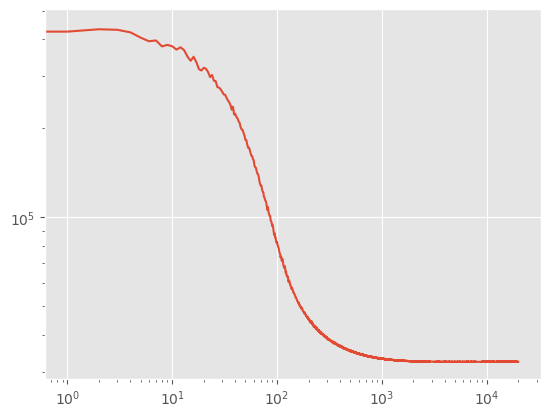

In [27]:
# Do a single run and expect the result
if (True):
    seed = 1954
    n_iter_optimizer = int(20e3)
    loss_saved, time_fvi = run_fvi(seed, n_iter_optimizer)
    print("loss", loss_saved[n_iter_optimizer - 1].data)
    plt.plot(loss_saved)
    plt.yscale("log")
    plt.xscale("log")

### Amortized VI

In [32]:
def run_avi(seed, inf_nn_width, n_iter_optimizer, print_output = False):
    torch.manual_seed(seed)
    model_av = MCElbo_AVI(inf_nn_width).to(device)
    
    optimizer = torch.optim.Adam(model_av.parameters(), lr = 1e-2)
    
    loss_av_saved = torch.empty((n_iter_optimizer,)) # np.empty(n_iter_optimizer)

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss_av = - model_av.compute_elbo(x)
        optimizer.zero_grad()
        loss_av.backward()
        optimizer.step()
        loss_av_saved[i] = loss_av.data
        if i % 5000 == 0 and print_output:
            print("loss", loss_av_saved[i])
    end_time = time.time()
    run_time = end_time - start_time
    return loss_av_saved, run_time

In [31]:
if False:
    n_iter_optimizer = int(20e3)
    loss_av_1_saved = run_avi(seed, 1, n_iter_optimizer)
    loss_av_2_saved = run_avi(seed, 2, n_iter_optimizer)
    n_iter4_saved = run_avi(seed, 4, n_iter_optimizer)
    loss_av_8_saved = run_avi(seed, 8, n_iter_optimizer)
    loss_av_16_saved = run_avi(seed, 16, n_iter_optimizer)
    loss_av_24_saved = run_avi(seed, 24, n_iter_optimizer)
    loss_av_32_saved = run_avi(32, seed, n_iter_optimizer)
# with a width of 24, start getting numerical instability

In [38]:
# function to run the experiments over multiple seeds
def run_experiment(seed, n_iter_optimizer, nn_widths, init_manifold = False, include_fvi = True):
    loss_all = torch.empty((n_iter_optimizer, 1 + nn_widths.size))
    saved_times = np.empty(1 + nn_widths.size)

    for i in range(nn_widths.size):
        loss_avi, time_avi = run_avi(seed, nn_widths[i], n_iter_optimizer)
        loss_all[:, i + 1] = loss_avi
        saved_times[i + 1] = time_avi
    
    if include_fvi:
        loss_fvi, time_fvi = run_fvi(seed, n_iter_optimizer, init_manifold)
        loss_all[:, 0] = loss_fvi
        saved_times[0] = time_fvi


    np.save("deliv/nonlin_loss_" + str(seed) + "_lock" + str(init_manifold), loss_all.detach().numpy())
    np.save("deliv/nonlin_time_" + str(seed) + "_lock" + str(init_manifold), saved_times)


In [42]:
nn_widths = np.array([1, 2, 4, 8, 16, 24, 32])

init_seed = 1789
for i in range(10):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed, n_iter_optimizer, nn_widths = nn_widths, init_manifold = False)


seed:  1789
seed:  1790
seed:  1791
seed:  1792
seed:  1793
seed:  1794
seed:  1795
seed:  1796
seed:  1797
seed:  1798


## Analyze results
Let's start by analyzing one realization of the experiment.

In [45]:
# read saved input
seed = 1789
init_manifold = False
loss_all = np.load("deliv/nonlin_loss_" + str(seed) + "_lock" + str(init_manifold) + ".npy")

loss_saved = loss_all[:, 0]


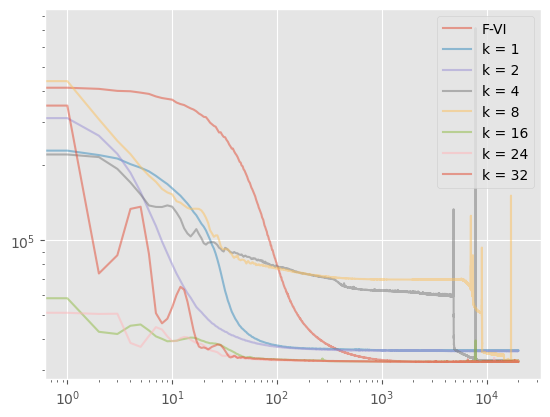

In [54]:
plt.plot(loss_all[:, 0], label = 'F-VI', alpha = 0.5)
nn_widths = np.array([1, 2, 4, 8, 16, 24, 32])
for i in range(nn_widths.size):
    plt.plot(loss_all[:, i + 1], label = "k = " + str(nn_widths[i]), alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")


In [53]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 
    

In [56]:
# Get asymptotic ELBO
window = 500
index_center = n_iter_optimizer - window
print("FVI: ", mean_window(loss_all[:, 0], index_center, window), " +/- ",
      sd_window(loss_all[:, 0], index_center, window))

for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ", mean_window(loss_all[:, i + 1],
        index_center, window), " +/- ",
        sd_window(loss_all[:, i], index_center, window))


FVI:  32399.115  +/-  4.2339544
k = 1:  36007.516  +/-  4.2339544
k = 2:  35799.504  +/-  15.073791
k = 4:  32784.605  +/-  15.059065
k = 8:  32682.64  +/-  6.199298
k = 16:  32386.156  +/-  8.820007
k = 24:  32386.057  +/-  4.228036
k = 32:  32385.385  +/-  4.2396812


In [60]:
## Estimate of the convergence
# If oracle = False, compare subsequent windows.
def iter_convergence(loss, rel_tol = 0.01, init_iteration = 10, window = 10,
                     grid = 10, max_iteration = 20000, oracle = True, set_target = 0):
    iteration = init_iteration
    tol = 0
    diff = tol + 1
    while(diff > tol and iteration < max_iteration):
        iteration += grid
        if (oracle):
            target = set_target
        else:
            target = mean_window(loss, iteration - grid, window)

        tol = rel_tol * abs(target)
        diff = abs(mean_window(loss, iteration, window) - target)
        # print("diff:", diff)
        # print("tol:", tol)
    return iteration

# Q: should we report convergence to F-VI's solution or for each individual solution?
def iter_conv_wrapper(loss, loss_benchmark, rel_tol = 0.01, window = 10):
    return iter_convergence(loss, oracle = True, rel_tol = rel_tol,
                            set_target = mean_window(loss_benchmark, 19500, window))


In [62]:
print("FVI:", iter_conv_wrapper(loss_all[:, 0], loss_all[:, 0]))
for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ",
        iter_conv_wrapper(loss_all[:, i + 1], loss_all[:, 0]))


FVI: 1210
k = 1:  20000
k = 2:  20000
k = 4:  20000
k = 8:  17950
k = 16:  290
k = 24:  170
k = 32:  230


In [63]:
# Get results across multiple seeds
init_seed = 1789
num_seed = 10
init_manifold = False
n_algorithms = 8
num_tol = 3
rel_tol = np.array([0.5, 0.1, 0.01])

iter_to_conv = np.empty((num_seed, n_algorithms, num_tol))
Elbo_final = np.empty((num_seed, n_algorithms)) 

for i in range(num_seed):
    loss_all = np.load("deliv/nonlin_loss_" + str(init_seed + i) + "_lock" + str(init_manifold) + ".npy")

    for j in range(n_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:, j], n_iter_optimizer - window, window)
        for k in range(num_tol):
            # Use F-VI as the benchmark for the asymptotic ELBO
            iter_to_conv[i, j, k] = iter_conv_wrapper(loss_all[:, j], loss_all[:, 0], rel_tol[k])


In [65]:
print("mean iter:\n", np.median(iter_to_conv, axis = 0))
print("min iter:\n", np.min(iter_to_conv, axis = 0))
print("max iter:\n", np.max(iter_to_conv, axis = 0))
print(np.mean(Elbo_final, axis = 0))

mean iter:
 [[  180.   440.  1280.]
 [   65. 20000. 20000.]
 [   60.   540. 20000.]
 [   40.   160.  1045.]
 [   20.    65.  1060.]
 [   20.    60.   555.]
 [   20.    65.   520.]
 [   25.    45.   250.]]
min iter:
 [[  170.   410.  1200.]
 [   20.  2330. 20000.]
 [   20.    50.  2140.]
 [   20.    20.   230.]
 [   20.    20.   110.]
 [   20.    40.   170.]
 [   20.    30.   160.]
 [   20.    20.    20.]]
max iter:
 [[  250.   780.  2680.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [ 9020.  9080. 20000.]
 [20000. 20000. 20000.]
 [17930. 17930. 17930.]
 [15910. 20000. 20000.]]
[3.23990402e+04 3.96557605e+04 3.74381424e+04 3.93635100e+04
 3.25944828e+04 8.15405111e+13            nan            nan]


### Draft code

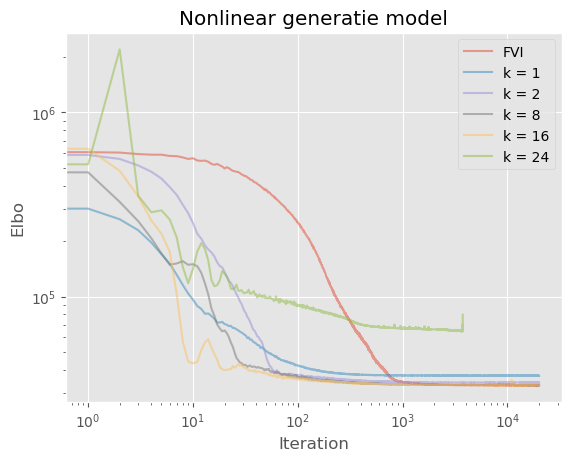

In [95]:
plt.plot(loss_saved, label = 'FVI', alpha = 0.5)
plt.plot(loss_av_1_saved, label = 'k = 1', alpha = 0.5)
plt.plot(loss_av_2_saved, label = 'k = 2', alpha = 0.5)
# # plt.plot(loss_av_4_saved, label = 'k = 4', alpha = 0.5)
plt.plot(loss_av_8_saved, label = 'k = 8', alpha = 0.5)
plt.plot(loss_av_16_saved, label = 'k = 16', alpha = 0.5)
plt.plot(loss_av_24_saved, label = 'k = 24', alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
# plt.title("Elbo, n = " + str(n))
# ax = plt.gca()
# #ax.set_ylim([32000, 130000])
plt.title("Nonlinear generatie model")
plt.xlabel("Iteration")
plt.ylabel("Elbo")

# ax = plt.axes()
ax.set_facecolor("white")
plt.savefig("to_discuss/elbo_nonlin" + str(seed) +".pdf")
plt.show()


In [96]:
seed

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


1954

In [ ]:
def mean_window(loss, index_center, window):
    return torch.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return torch.std(loss[(index_center - window):(index_center + window)]) 

: 

In [ ]:
# Get asymptotic ELBO
index_center = 19000
window = 1000
print("FVI: ", mean_window(loss_saved, index_center, window), " +/- ",
     sd_window(loss_saved, index_center, window))
print("k = 1: ", mean_window(loss_av_1_saved, index_center, window), " +/- ",
     sd_window(loss_av_1_saved, index_center, window))
print("k = 2: ", mean_window(loss_av_2_saved, index_center, window), " +/- ",
     sd_window(loss_av_2_saved, index_center, window))
print("k = 8: ", mean_window(loss_av_8_saved, index_center, window), " +/- ",
     sd_window(loss_av_8_saved, index_center, window))
print("k = 16: ", mean_window(loss_av_16_saved, index_center, window), " +/- ",
     sd_window(loss_av_16_saved, index_center, window))
print("k = 24: ", mean_window(loss_av_24_saved, index_center, window), " +/- ",
     sd_window(loss_av_24_saved, index_center, window))

FVI:  tensor(32370.6270)  +/-  tensor(4.2772)
k = 1:  tensor(36489.3555)  +/-  tensor(14.4517)
k = 2:  tensor(33542.2539)  +/-  tensor(5.8834)
k = 8:  tensor(32387.3242)  +/-  tensor(4.3300)
k = 16:  tensor(32386.5547)  +/-  tensor(8.0608)
k = 24:  tensor(32385.7344)  +/-  tensor(4.3512)


: 

In [ ]:
index_center = 4500
window = 10
print(np.mean(loss_saved[(index_center - window):(index_center + window)]))
print(np.std(loss_saved[(index_center - window):(index_center + window)]))

print(np.mean(loss_av_saved[(index_center - window):(index_center + window)]))
print(np.std(loss_av_saved[(index_center - window):(index_center + window)]))

14427.575244140626
10.01549769411398
14401.196826171876
14.69895580331285


: 

In [ ]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 

: 

In [ ]:
FVI = [mean_window(loss_saved, 100, 10),
      mean_window(loss_saved, 1000, 10),
      mean_window(loss_saved, 4500, 10)]

FVI_err = [sd_window(loss_saved, 100, 10),
          sd_window(loss_saved, 1000, 10),
          sd_window(loss_saved, 4500, 10)]

AVI = [mean_window(loss_av_saved, 100, 10),
      mean_window(loss_av_saved, 1000, 10),
      mean_window(loss_av_saved, 4500, 10)]

AVI_err = [sd_window(loss_av_saved, 100, 10),
          sd_window(loss_av_saved, 1000, 10),
          sd_window(loss_av_saved, 4500, 10)]

: 

In [ ]:
print("FVI: ", FVI)
print("AVI:", AVI)

FVI:  [17447.890625, 14440.43642578125, 14427.575244140626]
AVI: [15262.216162109375, 14630.1435546875, 14401.196826171876]


: 

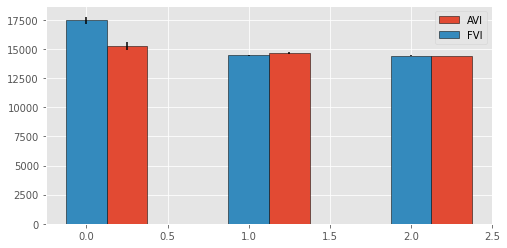

: 

In [ ]:
barWidth = 0.25
fig = plt.subplots(figsize = (8, 4))

br1 = np.arange(len(FVI))
br2 = [x + barWidth for x in br1]

plt.bar(br2, AVI, width = barWidth, edgecolor = 'black', yerr = AVI_err, label = 'AVI')
plt.bar(br1, FVI, width = barWidth, edgecolor = 'black', yerr = FVI_err, label = 'FVI')
plt.legend()

: 